In [1]:
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import os
from copy import deepcopy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from itertools import permutations
import torch.nn.functional as F
# from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import vector
from tqdm.notebook import tqdm
import yaml

In [2]:
yaml_name='Aug16_simple.yaml'

In [3]:
base_path = os.path.dirname(os.getcwd())

full_folder_path = os.path.join(base_path,"saved_files", "fake_data")

yaml_file_path= os.path.join(base_path, "fnn_FeatureRegression", 'yamls', yaml_name)
with open(yaml_file_path, 'r') as yaml_file:
    loaded_data = yaml.load(yaml_file, Loader=yaml.SafeLoader)

# Extract the general configurations
data_name = loaded_data['data_name']
batch_size = loaded_data['batch_size']
early_stop_patience = loaded_data['early_stop_patience']
learning_rate = loaded_data['learning_rate']
Local_model=loaded_data['Local_model']
model_save_prefix=loaded_data['model_save_prefix']

# Extracting model configurations
models = loaded_data['models']
hidden_layers_list_loaded = [model['hidden_layers'] for model in models]
activation_fn_names_loaded = [model['activation_fn'] for model in models]

# Map function names back to their actual functions
activation_fn_mapping = {
    'relu': F.relu,
    'sigmoid': F.sigmoid,
    'tanh': F.tanh
}

# Convert function names to actual functions
activation_fn_list_loaded = [activation_fn_mapping[name] for name in activation_fn_names_loaded]


In [4]:
base_path = os.path.dirname(os.getcwd())

full_folder_path = os.path.join(base_path,"saved_files", "fake_data")
# data_df=pd.read_pickle(os.path.join(full_folder_path,"Aug7_1mil.pkl"))
# with open(os.path.join(full_folder_path,"Aug10_5mil.pkl"), 'rb') as f:
with open(os.path.join(full_folder_path,data_name), 'rb') as f:
    clean_data_dict = pickle.load(f)
print(clean_data_dict.keys())
numevents=len(clean_data_dict['2_phi'])
print("number of events:",numevents)

data_dict=clean_data_dict
print(data_dict.keys())

data_dict_np={}
for key in data_dict.keys():
    data_dict_np[key]=np.array(data_dict[key])

yaml_file_path= os.path.join(base_path, "fnn_FeatureRegression", 'yamls', yaml_name)


dict_keys(['event', 'genWeight', 'MET_phi', '1_phi', '1_genPartFlav', '2_phi', '2_genPartFlav', '3_phi', '3_genPartFlav', 'charge_1', 'charge_2', 'charge_3', 'pt_1', 'pt_2', 'pt_3', 'pt_MET', 'eta_1', 'eta_2', 'eta_3', 'mass_1', 'mass_2', 'mass_3', 'deltaphi_12', 'deltaphi_13', 'deltaphi_23', 'deltaphi_1MET', 'deltaphi_2MET', 'deltaphi_3MET', 'deltaphi_1(23)', 'deltaphi_2(13)', 'deltaphi_3(12)', 'deltaphi_MET(12)', 'deltaphi_MET(13)', 'deltaphi_MET(23)', 'deltaphi_1(2MET)', 'deltaphi_1(3MET)', 'deltaphi_2(1MET)', 'deltaphi_2(3MET)', 'deltaphi_3(1MET)', 'deltaphi_3(2MET)', 'deltaeta_12', 'deltaeta_13', 'deltaeta_23', 'deltaeta_1(23)', 'deltaeta_2(13)', 'deltaeta_3(12)', 'deltaR_12', 'deltaR_13', 'deltaR_23', 'deltaR_1(23)', 'deltaR_2(13)', 'deltaR_3(12)', 'pt_123', 'mt_12', 'mt_13', 'mt_23', 'mt_1MET', 'mt_2MET', 'mt_3MET', 'mt_1(23)', 'mt_2(13)', 'mt_3(12)', 'mt_MET(12)', 'mt_MET(13)', 'mt_MET(23)', 'mt_1(2MET)', 'mt_1(3MET)', 'mt_2(1MET)', 'mt_2(3MET)', 'mt_3(1MET)', 'mt_3(2MET)', 'ma

In [5]:
input_data_names_ordered = [
    ['MET_phi', 'pt_MET'], 
    ['1_phi', 'pt_1', 'eta_1', 'mass_1'], 
    ['2_phi', 'pt_2', 'eta_2', 'mass_2'], 
    ['3_phi', 'pt_3', 'eta_3', 'mass_3']
]
input_data_particle_order = ['MET', '1', '2', '3']

pair_order = ["MET_1", "MET_2", "MET_3", "1_2", "1_3", "2_3"]
used_labels2 = [
    ['deltaphi_1MET', 'mt_1MET'], 
    ['deltaphi_2MET', 'mt_2MET'], 
    ['deltaphi_3MET', 'mt_3MET'], 
    ['norm_mt_12'], 
    ['norm_mt_13'], 
    [ 'norm_mt_23']
]

lepton_input_ordered = input_data_names_ordered[1:]
lepton_output_ordered = used_labels2[3:]

l_input_shape=(numevents,len(lepton_input_ordered), len(lepton_input_ordered[0]))
print("events, particles, input features: ",l_input_shape)
l_input= np.empty(l_input_shape)

for i in range(len(lepton_input_ordered)):
    for j, feature in enumerate(lepton_input_ordered[i]):
        l_input[:,i,j] = data_dict_np[feature]

l_output_shape=(numevents, len(lepton_output_ordered), len(lepton_output_ordered[0]))
print("events, particle pairs, output kin. features: ",l_output_shape)
l_output= np.empty(l_output_shape)

for i in range(len(lepton_output_ordered)):
    for j, feature in enumerate(lepton_output_ordered[i]):
        l_output[:,i,j] = data_dict_np[feature]

lepton_pair_order = pair_order[3:]
lepton_particle_order = input_data_particle_order[1:]
print("lepton pair order: ", lepton_pair_order)
print("lepton particle order: ", lepton_particle_order)

events, particles, input features:  (2844237, 3, 4)
events, particle pairs, output kin. features:  (2844237, 3, 1)
lepton pair order:  ['1_2', '1_3', '2_3']
lepton particle order:  ['1', '2', '3']


In [6]:
print(l_input.shape)
pair_input_order=[(0,1),(0,2),(1,2), (1,0),(2,0),(2,1)]
# datashape=(numevents*len(pair_input_order),l_input.shape[2]*2)
datashape=(numevents,l_input.shape[2]*6*2)
print("datashape",datashape)
data=np.array(np.zeros(datashape))
for i in range(len(pair_input_order)):
    combined=np.concatenate((l_input[:,pair_input_order[i][0],:],l_input[:,pair_input_order[i][1],:]),axis=1)
    # print(combined.shape)
    #add to data
    data[:,i*combined.shape[1]:(i+1)*combined.shape[1]]=combined


print(data.shape)
labels=l_output.reshape((numevents,3))
print(labels.shape)

(2844237, 3, 4)
datashape (2844237, 48)
(2844237, 48)
(2844237, 3)


In [7]:
class particleDataset(Dataset):
    def __init__(self, data, labels):
        self.data=data
        self.labels=labels
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        return self.data[idx],self.labels[idx]


batch = 320
x_tensor = torch.from_numpy(data).float()
y_tensor = torch.from_numpy(labels).float()

# dataset=particleDataset(data,y)
dataset=TensorDataset(x_tensor,y_tensor)

train_val_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
training_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=42)

train_loader=DataLoader(training_data, batch_size=batch, shuffle=True)
test_loader=DataLoader(test_data, batch_size=batch, shuffle=False)
val_loader=DataLoader(val_data, batch_size=batch, shuffle=False)

# train_loader=DataLoader(dataset, batch_size=batch, shuffle=True)
#make trainloader using data as x and y as labels
# trainloader=DataLoader(data, batch_size=batch, shuffle=True)
# train_dataset= 
# trainloader=DataLoader(data, batch_size=batch, shuffle=True)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class KinematicNet(nn.Module):
    def __init__(self):
        super(KinematicNet, self).__init__()
        self.fc1 = nn.Linear(48, 32)
        self.fc2 = nn.Linear(32, 10)
        self.fc3 = nn.Linear(10, 3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

model = KinematicNet()
model.to(device)

KinematicNet(
  (fc1): Linear(in_features=48, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=3, bias=True)
)

In [9]:
optimizer=torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
loss_fn=nn.MSELoss()



numepochs=10000
best_loss=np.inf
for epoch in range(numepochs):
    model.train()
    train_loss=0
    for i, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader), leave=False, position=0, disable=True):
        x=x.to(device)
        y=y.to(device)
        # print(x.shape)
        # print(y.shape)
        y_pred=model(x)
        loss=loss_fn(y_pred, y)
        train_loss+=loss.item()
        # if i%100==0:
        #     print('currloss: ', loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    patience=20
    with torch.no_grad():
        valloss=0
        for i, (x, y) in tqdm(enumerate(val_loader), total=len(val_loader), leave=False, position=0, disable=True):
            x=x.to(device)
            y=y.to(device)
            y_pred=model(x)
            valloss+=loss_fn(y_pred, y)
        if valloss.item()<best_loss:
            best_loss=valloss.item()
            patience=20
            modelsave=deepcopy(model.state_dict())
        else:
            patience-=1
            if patience==0:
                print('early stopping')
                break

            # if loss.item()<best_loss:
            #     best_loss=val_loss.item()
            #     patience=20
            #     modelsave=deepcopy(model.state_dict())
            # else:
            #     patience-=1
            #     if patience==0:
            #         print('early stopping')
            #         break


    print('epoch: ', epoch, 'train_loss: ', train_loss/len(train_loader), 'val_loss: ', valloss.item()/len(val_loader))
    

epoch:  0 train_loss:  0.1731260068638741 val_loss:  0.0006760008219506484
epoch:  1 train_loss:  0.00017037513453608698 val_loss:  7.569689096821419e-06
epoch:  2 train_loss:  3.1880196597944628e-06 val_loss:  8.73987333232554e-07
epoch:  3 train_loss:  1.3168528406052009e-06 val_loss:  6.557223897555599e-08
epoch:  4 train_loss:  9.149265494734524e-07 val_loss:  7.78498364977659e-06
epoch:  5 train_loss:  7.816249378295572e-07 val_loss:  4.117184685764393e-06
epoch:  6 train_loss:  6.873230576286129e-07 val_loss:  7.2020022090977985e-09
epoch:  7 train_loss:  4.683290095721564e-07 val_loss:  3.274391330919312e-08
epoch:  8 train_loss:  4.337664587397328e-07 val_loss:  4.7210452358879134e-08
epoch:  9 train_loss:  3.1446053320253225e-07 val_loss:  1.1278569017430912e-08
epoch:  10 train_loss:  2.496240134577466e-07 val_loss:  1.7812069867379592e-07
epoch:  11 train_loss:  1.72634863002785e-07 val_loss:  2.664363450565927e-09
epoch:  12 train_loss:  1.3922139949461636e-07 val_loss:  8.

KeyboardInterrupt: 

(1706544,)


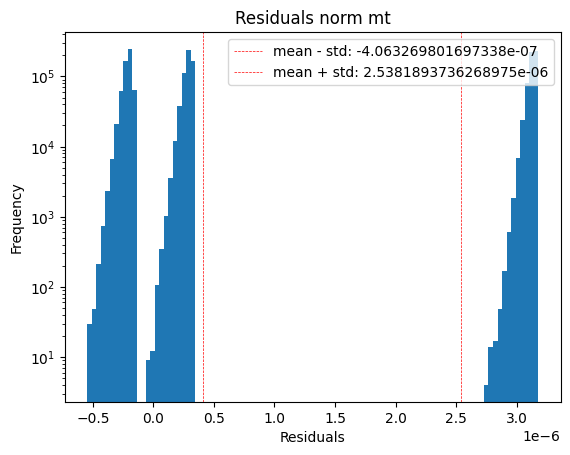

mean:  1.0659311967285819e-06
std:  1.4722581768983157e-06


In [10]:
# plotting histogram
modeltest= KinematicNet()
modeltest.load_state_dict(modelsave)
modeltest.to(device)

residuals=np.array([])
for i, (x,y) in enumerate(test_loader):
    x = x.to(device)
    y = y.to(device)
    y_pred = model(x)

    residuals=np.append(residuals, y_pred.cpu().detach().numpy() - y.cpu().detach().numpy())

    # residuals.append(y_pred.cpu().detach().numpy() - y.cpu().detach().numpy())

# residuals = np.array(residuals)
print(residuals.shape)
mean = np.mean(residuals)
std = np.std(residuals)
plt.hist(residuals, bins=100)
plt.axvline(x=std-mean, color='r', linestyle='dashed', linewidth=0.5, label='mean - std: '+str(mean-std))
plt.axvline(x=std+mean, color='r', linestyle='dashed', linewidth=0.5, label='mean + std: '+str(mean+std))
plt.yscale('log')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals norm mt')
plt.legend()

plt.show()
print('mean: ', mean)
print('std: ', std)
    
    